In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# pandas option to display all columns when printing df.head()
pd.set_option('display.max_columns', None)

In [34]:
# reading the data 
# converting the 23rd column 'Unnamed 22' column to string, which originally had a mix of bool and NaN values (nan and False)
df = pd.read_csv('AmazonDataSales.csv', dtype={23: str})

### Data Cleaning and Preprocessing

Cleaning the column names to snake_case for simplicity

In [35]:
# clean the column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_')
df.head(1)

,index,order_id,date,status,fulfilment,sales_channel,ship_service_level,style,sku,category,size,asin,courier_status,qty,currency,amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,b2b,fulfilled_by,unnamed:_22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,NaN,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN


Inspecting the data by looking at how many rows and columns we are working with and how many nan values we have

In [36]:
# print the shape of the data
print(f' shape: ', df.shape)
# checking for nan values in all columns
print('count of nan values:')
# count of nan values in all columns descending order
print(df.isna().sum().sort_values(ascending=False).head(11))

 shape:  (128975, 24)
count of nan values:
fulfilled_by          89698
promotion_ids         49153
unnamed:_22           49050
currency               7795
amount                 7795
courier_status         6872
ship_country             33
ship_postal_code         33
ship_state               33
ship_city                33
ship_service_level        0
dtype: int64


### Handling the zero values in 'qty' and 'amount'
Since this is our second go at this dataset we are already familiar with the nature of zero values in 'qty' and 'amount' columns <br>
I have already decided to drop the rows with nan values in 'amount' which is 5.9% of total rows, because the orders are all cancelled <br>


In [37]:
total_rows = df.shape[0]
print(f'total rows: {total_rows}')

# drop rows with null values in 'amount'
df = df.dropna(subset=['amount'])

total_rows_after_drop = df.shape[0]
print(f'total rows after drop: {total_rows_after_drop}')

total rows: 128975
total rows after drop: 121180


#### After running the following codeblock we can see that we have zero values in both 'amount' and 'qty' but they are never both zero on row level <br>
We can see that when qty == 0 we only have status = Cancelled, since the goal with this exercise is to predict 'amount' I have decided to not work with Cancelled orders <br>
So in the following block we drop those rows <br><br>
We can also see that when amount == 0 we have various forms of Shipped and Pending status on the orders and no real explanation in the data as to why these items are "free" <br>
With this in mind i feel a loss of 2% of remaining rows is acceptable when the main goal is to predict amount with relevant data

In [38]:
# how many rows with zeros are there in 'amount' and 'qty' columns
print('amount column zeros:', len(df[df['amount'] == 0]))
print('qty column zeros:', len(df[df['qty'] == 0]))
# how many rows are there with both 'amount' and 'qty' equal to zero
print('amount and qty column zeros:', len(df[(df['amount'] == 0) & (df['qty'] == 0)]))
print('-'*50)
# value counts for 'qty' column when it is equal to zero
print('value counts of status when qty == 0')
print(df[df['qty'] == 0]['status'].value_counts())
print('-'*50)
# value counts for 'amount' column when it is equal to zero
print('value counts of status when amount == 0')
print(df[df['amount'] == 0]['status'].value_counts())
print('----', ' '*28, '----')
print('total rows where amount == 0:', ' '*3, len(df[df['amount'] == 0]))
print(f'total rows remaining:', total_rows_after_drop)
print(f'total rows after dropping rows:', total_rows_after_drop - len(df[df['amount'] == 0]))

amount column zeros: 2343
qty column zeros: 5136
amount and qty column zeros: 0
--------------------------------------------------
value counts of status when qty == 0
status
Cancelled    5136
Name: count, dtype: int64
--------------------------------------------------
value counts of status when amount == 0
status
Shipped                          1518
Shipped - Delivered to Buyer      716
Shipped - Returned to Seller       51
Shipped - Picked Up                28
Pending                            17
Pending - Waiting for Pick Up       9
Shipped - Lost in Transit           2
Shipped - Returning to Seller       2
Name: count, dtype: int64
----                              ----
total rows where amount == 0:     2343
total rows remaining: 121180
total rows after dropping rows: 118837


In [39]:
# drop rows where qty is 0, amount is 0
df = df[df['qty'] != 0]
df = df[df['amount'] != 0]

total_rows_final = df.shape[0]

print(f'total remaining rows: ', total_rows_final, '/', total_rows)

total remaining rows:  113701 / 128975


### Feature Selection <br>
The assignment is to predict 'amount' based on the features 'category', 'size' and 'qty' <br>
I have decided to keep it simple and not add any more features to be able to better dive into how the model works

In [40]:
# limit the columns to the ones we want to use as features
columns_to_keep = ['category', 'size', 'qty', 'amount']
df = df[columns_to_keep]
df.head(3)

,category,size,qty,amount
1,kurta,3XL,1,406.0
2,kurta,XL,1,329.0
4,Top,3XL,1,574.0


Cleaning the data my trimming potential whitespaces and converting to lower and uppercase depending on the nature of the data

In [41]:
# clean the data by converting the 'category' strings to lowercase and removing any empty spaces
df['category'] = df['category'].str.lower().str.strip()
# clean the 'size' column by converting the strings to uppercase, removing any empty spaces, and replacing 'FREE' with 'Free'
df['size'] = df['size'].str.upper().str.strip().str.replace('FREE', 'Free')

### Model Selection

First we check the numerical columns distribution and detect outliers

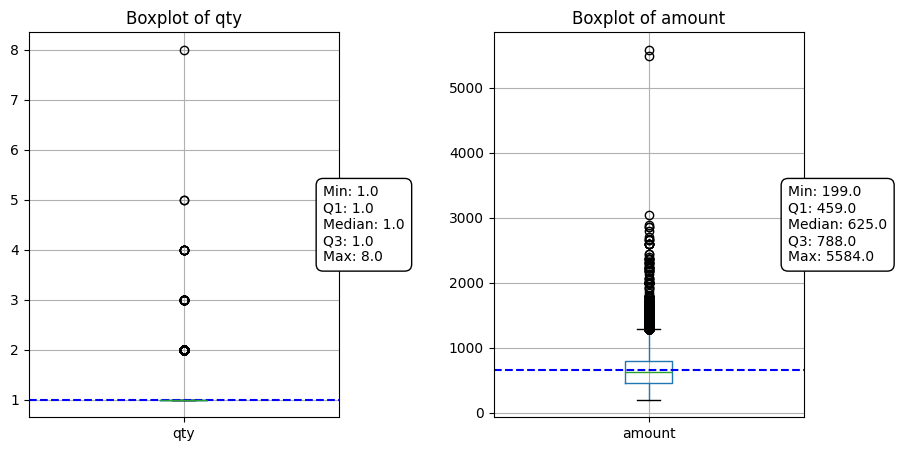

In [42]:
# box plots for investigating outliers in qty and amount columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, col in enumerate(['qty', 'amount']):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].axhline(y=df[col].mean(), color='b', linestyle='dashed')
    
    # adding describe to the boxplots
    stats = df[col].describe()
    text = f"Min: {stats['min']}\nQ1: {stats['25%']}\nMedian: {stats['50%']}\nQ3: {stats['75%']}\nMax: {stats['max']}"
    axes[i].text(0.95, 0.5, text, transform=axes[i].transAxes, verticalalignment='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.subplots_adjust(wspace=0.5)

plt.show()


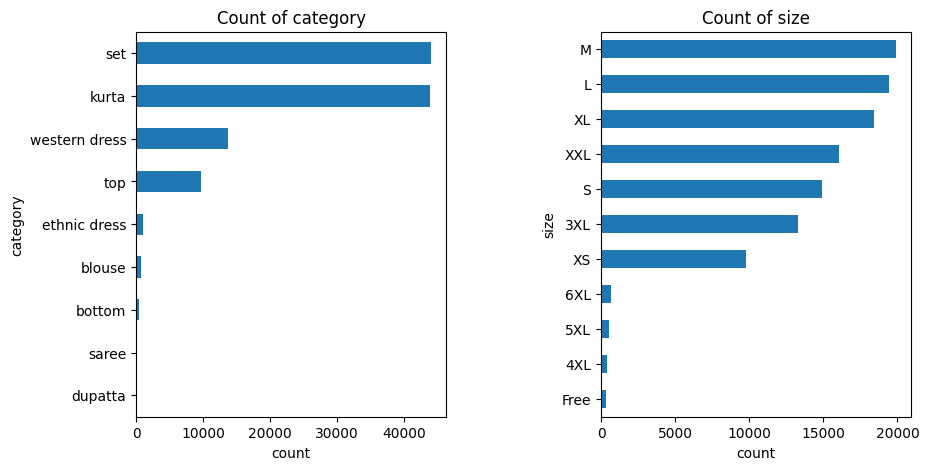

In [43]:
# horizontal bar plots for 'category' and 'size'
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, col in enumerate(['category', 'size']):
    df[col].value_counts().plot(kind='barh', ax=axes[i])
    axes[i].set_title(f"Count of {col}")
    axes[i].set_xlabel('count')
    axes[i].invert_yaxis()
    axes[i].set_ylabel(col)

plt.subplots_adjust(wspace=0.5)

plt.show()

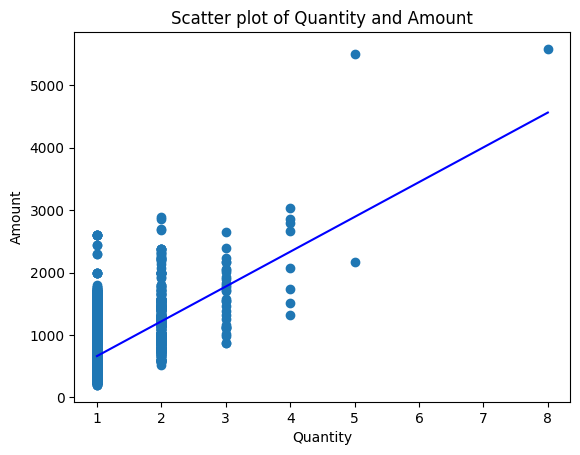

In [44]:
# scatter plot qty and amount
plt.scatter(df['qty'], df['amount'])
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.plot(np.unique(df['qty']), np.poly1d(np.polyfit(df['qty'], df['amount'], 1))(np.unique(df['qty'])), color='blue')
plt.title('Scatter plot of Quantity and Amount')
plt.show()

In [45]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# encode 'category' and 'size' columns
df['category_encoded'] = label_encoder.fit_transform(df['category'])
df['size_encoded'] = label_encoder.fit_transform(df['size'])

## Correlation Matrix

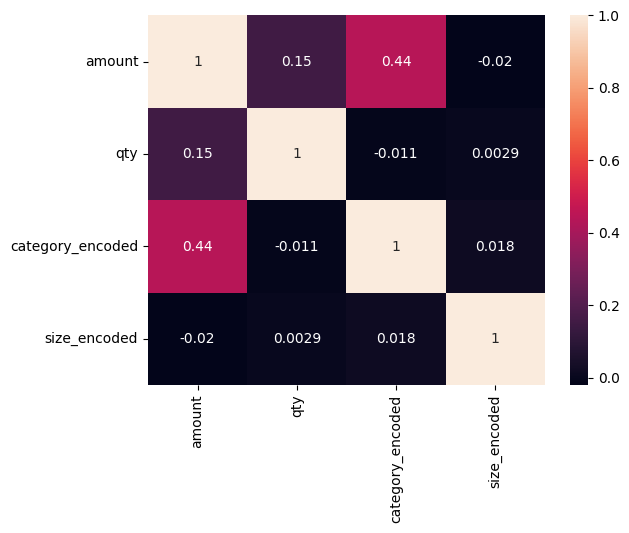

In [46]:
# correlation matrix
corr_cols = ['amount', 'qty', 'category_encoded', 'size_encoded']
correlation_matrix_label = df[corr_cols].corr()
sns.heatmap(correlation_matrix_label, annot=True)
plt.show()

In [47]:
# One-hot encode 'category' and 'size' columns
df_encoded = pd.get_dummies(df, columns=['category', 'size'])

<Axes: >

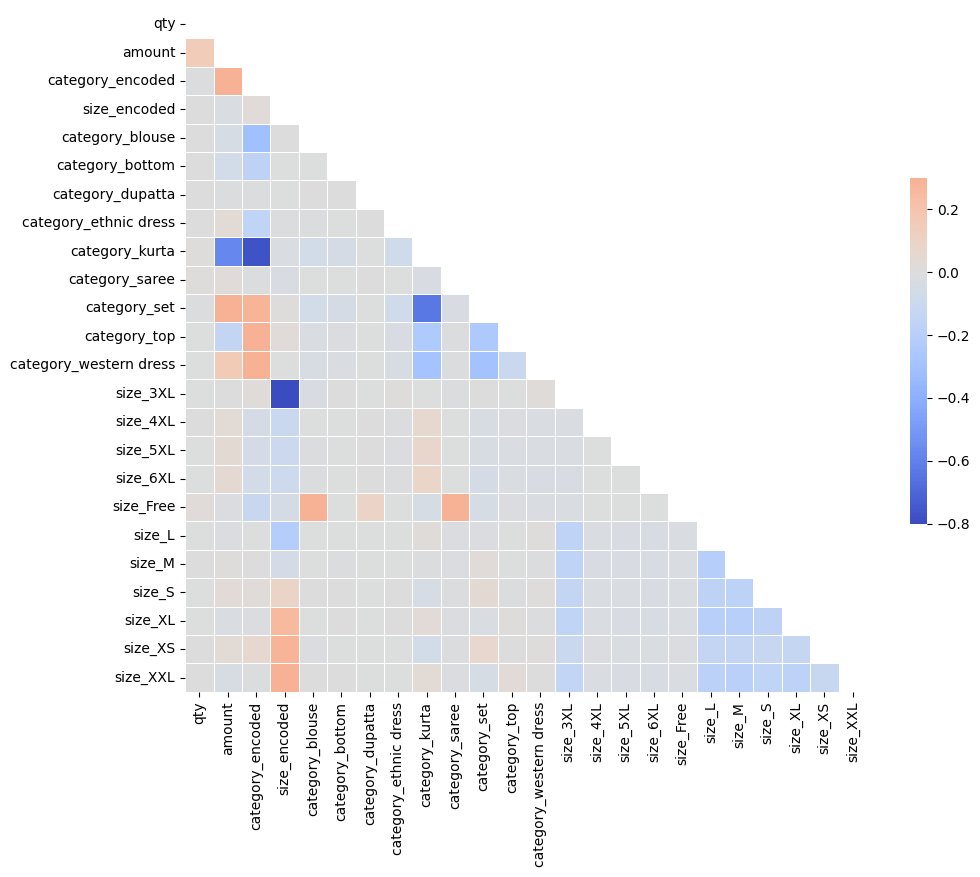

In [48]:
corr = df_encoded.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Takeaways: <br>
- The heatmap of features shows low correlations between features and the 'amount'. This suggests no single feature strongly predicts the target on its own.
- With these findings in mind, I'm choosing to go with a Decision Tree Regressor model which handles non-linear relationships in the data more effectively than a Linear model.
- Regarding outliers: I researched how to handle outliers when working with Decision Trees and found that the model is not sensitive to outliers, so the plan is to leave it as is for now.

In [49]:
# drop category encoded and size encoded columns
df = df.drop(columns=['category_encoded', 'size_encoded'])

In [50]:
df.head(1)

,category,size,qty,amount
1,kurta,3XL,1,406.0


In [51]:
# one-hot encode 'category' and 'size' columns
categorical_features = ['category', 'size']
one_hot_encoder = OneHotEncoder()
transformer = ColumnTransformer(transformers=[('cat', one_hot_encoder, categorical_features)], remainder='passthrough')
X = transformer.fit_transform(df.drop('amount', axis=1))

In [52]:
# split the data into train and test sets
y = df['amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [54]:
y_pred = decision_tree_model.predict(X_test)
mae = round(mean_absolute_error(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)
rmse = round(np.sqrt(mse), 3)
r2 = round(r2_score(y_test, y_pred), 4)
accuracy = round(decision_tree_model.score(X_test, y_test) * 100, 2)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')
print(f'Accuracy: {accuracy}%')

MAE: 140.66
MSE: 37084.46
RMSE: 192.573
R²: 0.4994
Accuracy: 49.94%
